### Notebook to analyse output of snow_processing
#### Imports

In [66]:
import xarray as xr

import matplotlib.pyplot as plt
import numpy as np
import iris
from iris.analysis import Aggregator
import iris.plot as iplt
import iris.quickplot as qplt
from iris.util import rolling_window

#### Code adjusted from Scitools Iri

In [67]:
# check for consecutive exceedance of threshholds:
#adjusted code example from https://scitools.org.uk/iris/docs/latest/examples/General/custom_aggregation.html


# Define a function to perform the custom statistical operation.
# Note: in order to meet the requirements of iris.analysis.Aggregator, it must
# do the calculation over an arbitrary (given) data axis.
def count_spells(data, threshold, axis, spell_length):
    """
    Function to calculate the number of points in a sequence where the value
    has exceeded a threshold value for at least a certain number of timepoints.

    Generalised to operate on multiple time sequences arranged on a specific
    axis of a multidimensional array.

    Args:

    * data (array):
        raw data to be compared with value threshold.

    * threshold (float):
        threshold point for 'significant' datapoints.

    * axis (int):
        number of the array dimension mapping the time sequences.
        (Can also be negative, e.g. '-1' means last dimension)

    * spell_length (int):
        number of consecutive times at which value > threshold to "count".

    """
    if axis < 0:
        # just cope with negative axis numbers
        axis += data.ndim
    # Threshold the data to find the 'significant' points.
    data_hits = data > threshold
    # Make an array with data values "windowed" along the time axis.
    hit_windows = rolling_window(data_hits, window=spell_length, axis=axis)
    # Find the windows "full of True-s" (along the added 'window axis').
    full_windows = np.all(hit_windows, axis=axis+1)
    # Count points fulfilling the condition (along the time axis).
    spell_point_counts = np.sum(full_windows, axis=axis, dtype=int)
    return spell_point_counts

def load_data_from_netcdf (filepath):
    # Load the whole data (as a list of cubes)
    file_path = (filepath)
    data = iris.load(file_path)
    return data

def get_cube_from_cubelist (data, variablename):
    return data[variablename]
    
def calculate_data_above_threshold_for_x_days(data, threshold, numberOfDays):
    
    # Make an aggregator from the user function.
    SPELL_COUNT = Aggregator('spell_count',
                             count_spells,
                             units_func=lambda units: 1)

    # Calculate the statistic
    data_above_threshold = data.collapsed('time', SPELL_COUNT,
                                  threshold=threshold,
                                  spell_length=numberOfDays)
    # TODO: customize label
    data_above_threshold.rename('Days with consecutive '+str(numberOfDays)+'-day snow falls above '+str(threshold)+'mm in timeperiod')
    return data_above_threshold
    
def contour_plot_intensity_data (data,contour_levels):  
    # Plot the results.
    qplt.contourf(data,contour_levels, cmap='YlGnBu')
    plt.gca().coastlines()
    iplt.show()


####  Analysis results

/home/quante/miniconda3/lib/python3.7/site-packages/iris/fileformats/cf.py:367: UserWarning: Missing CF-netCDF boundary variable 'time_bnds', referenced by netCDF variable 'time'
  warnings.warn(message % (name, nc_var_name))
/home/quante/miniconda3/lib/python3.7/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/home/quante/miniconda3/lib/python3.7/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/home/quante/miniconda3/lib/python3.7/site-packages/matplotlib/contour.py:1230: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


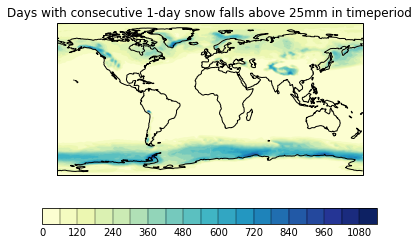

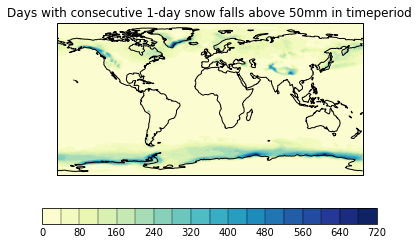

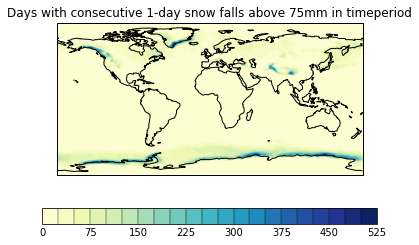

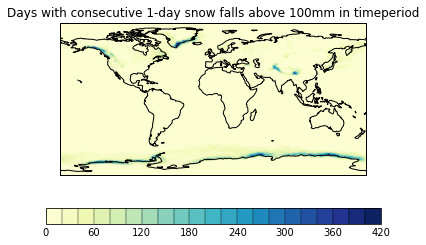

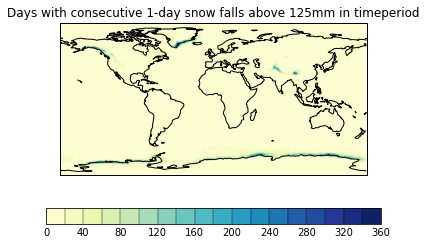

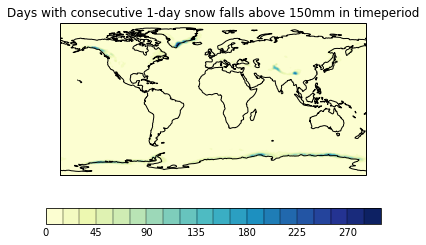

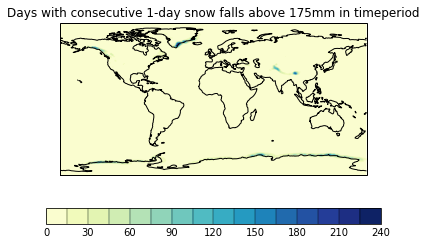

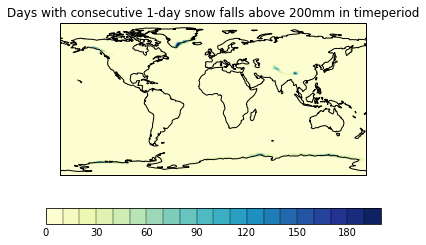

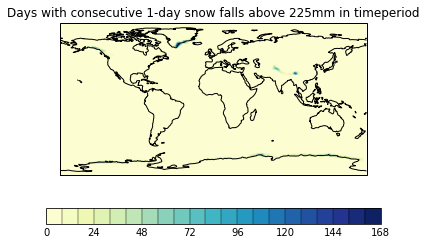

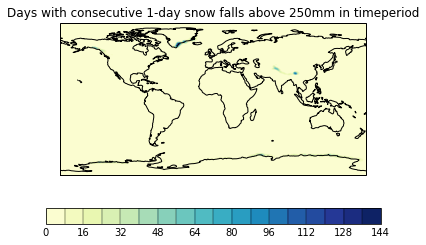

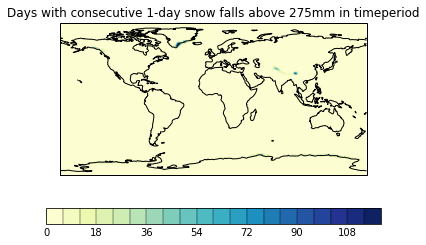

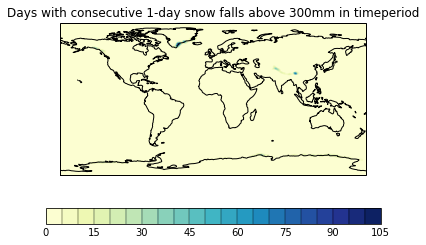

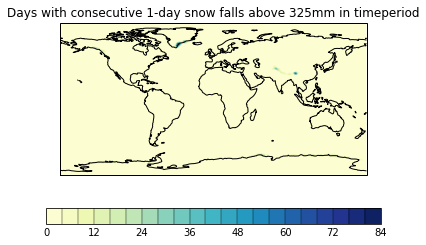

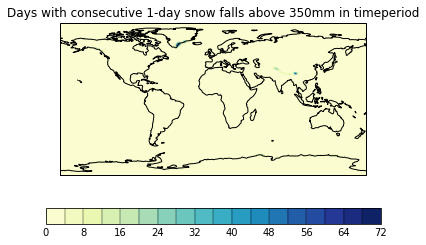

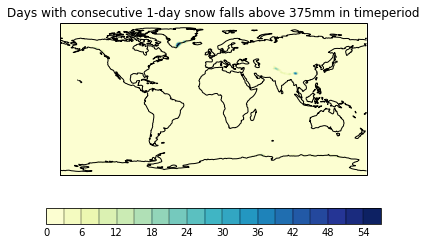

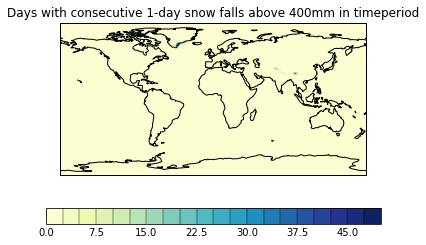

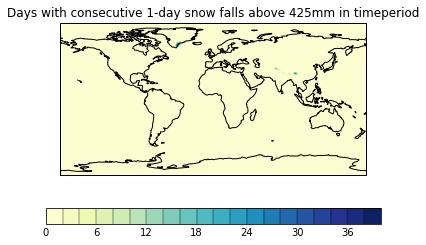

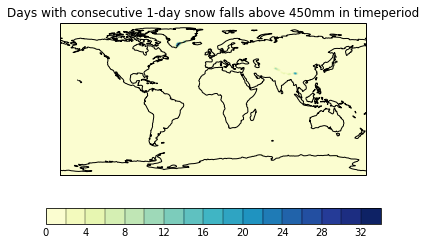

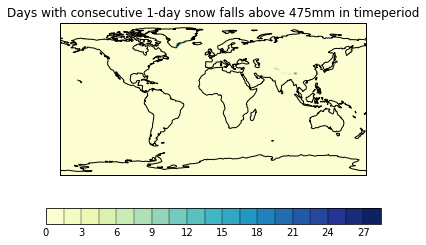

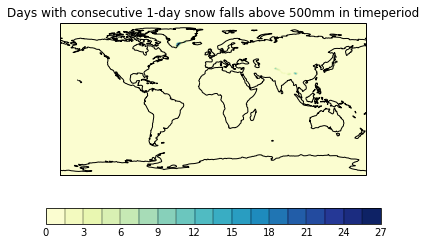

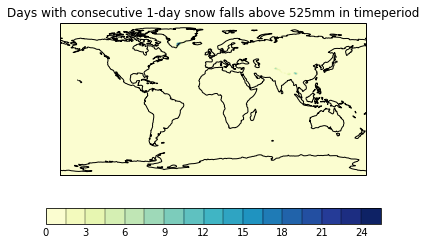

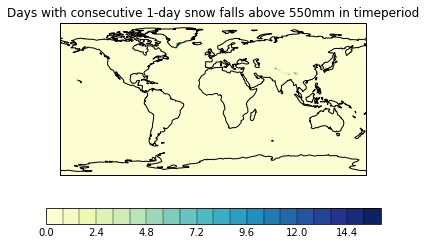

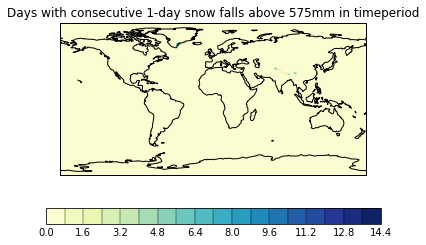

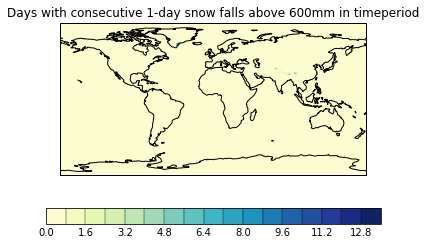

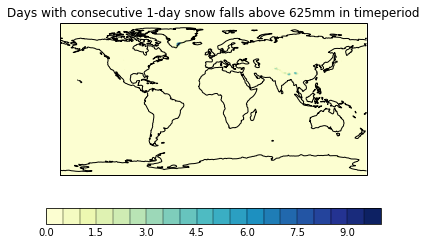

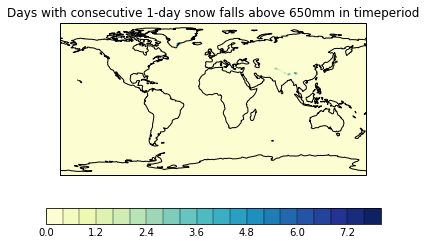

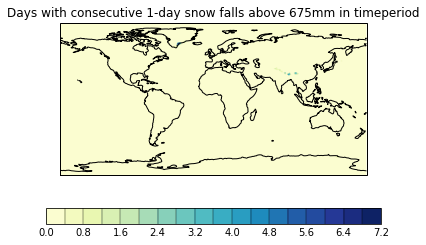

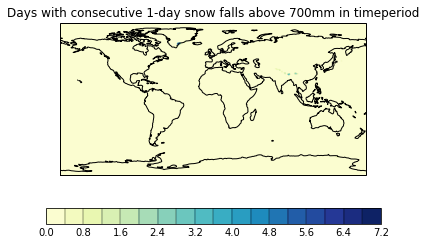

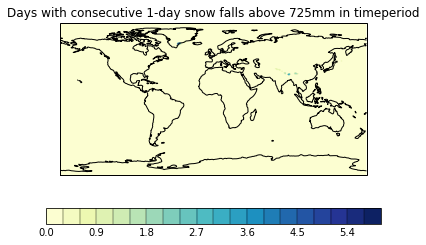

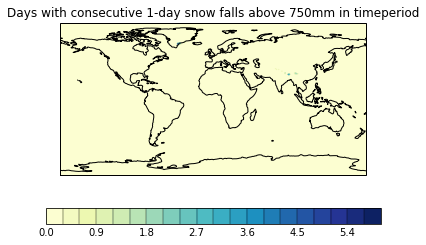

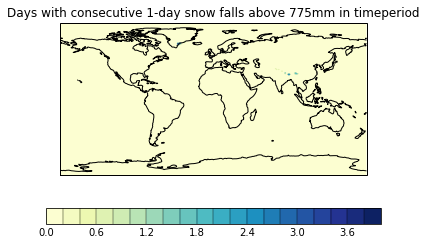

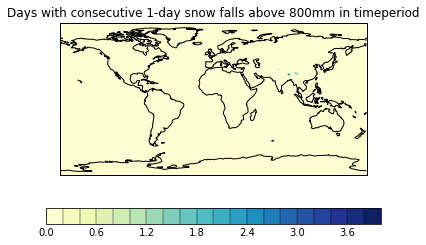

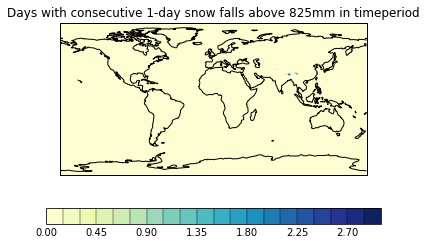

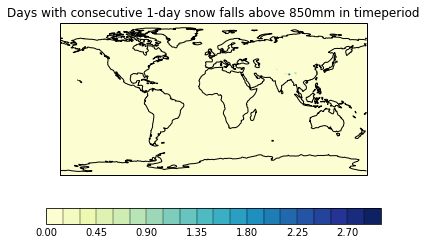

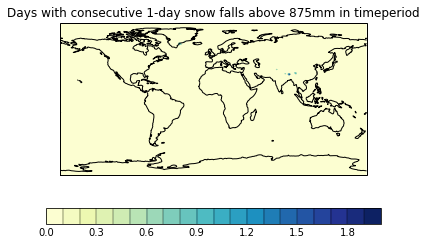

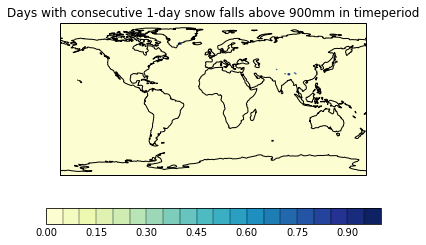

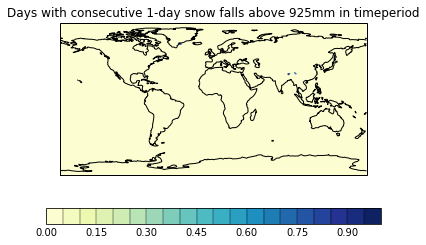

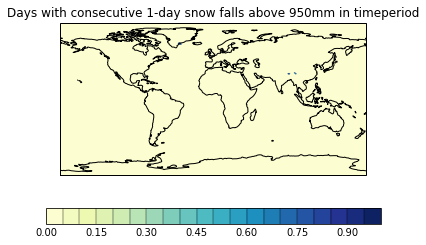

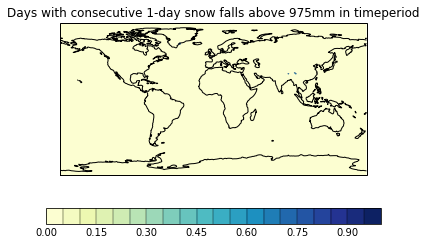

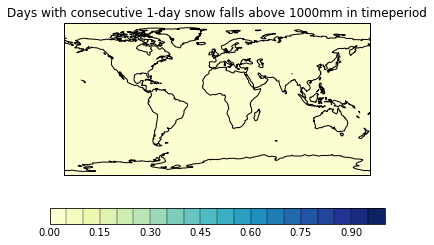

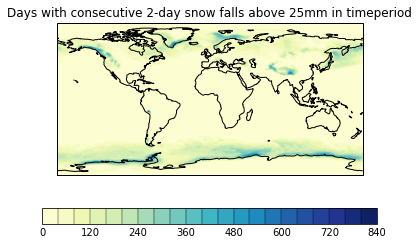

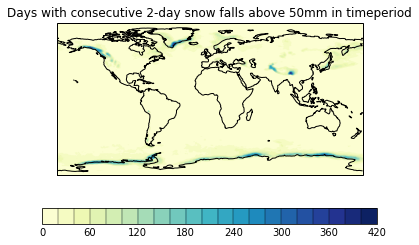

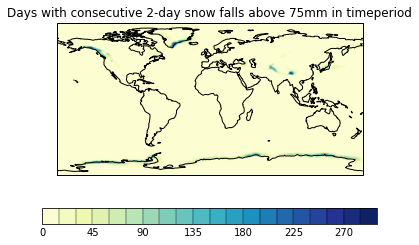

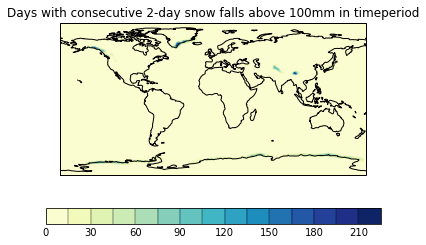

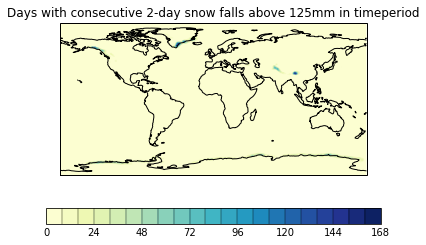

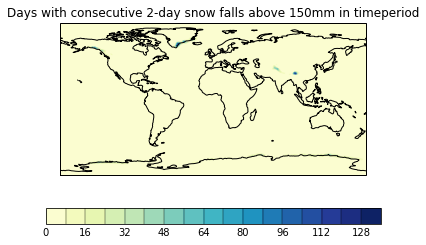

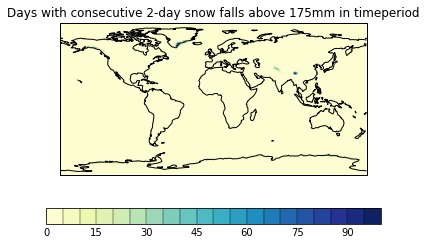

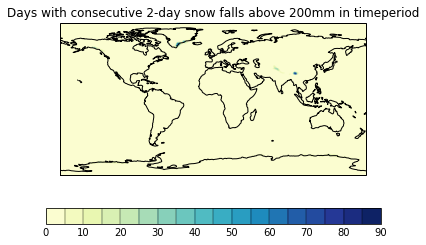

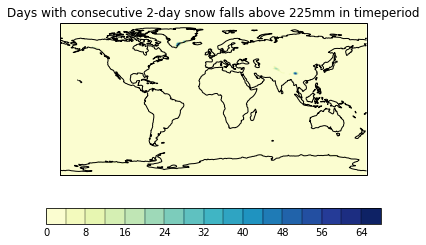

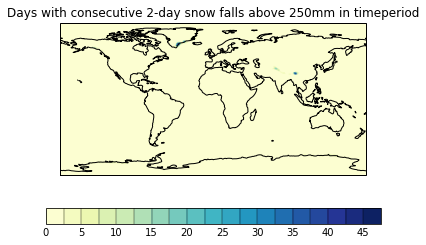

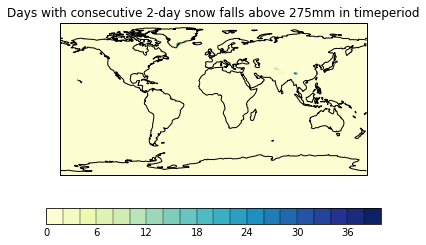

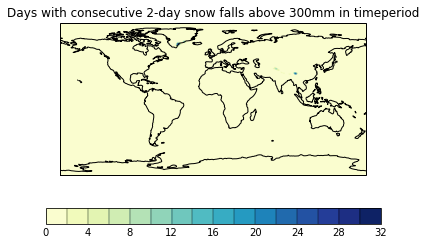

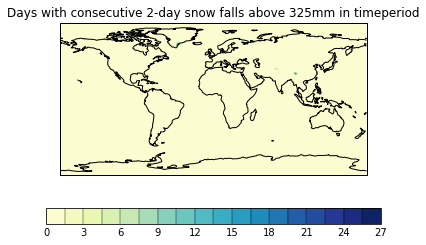

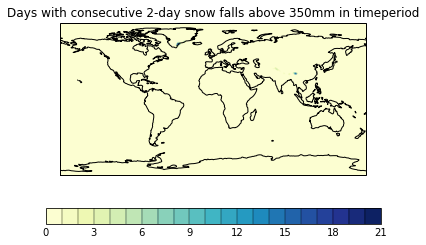

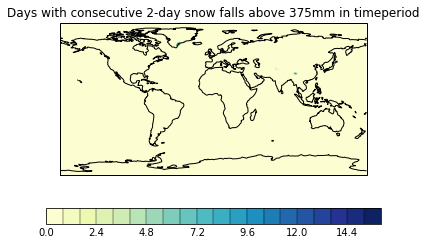

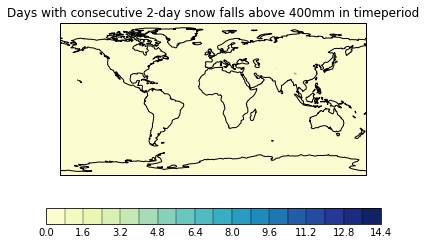

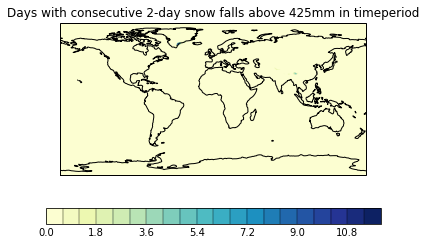

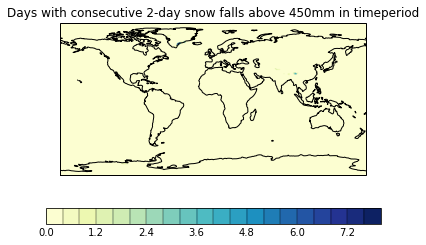

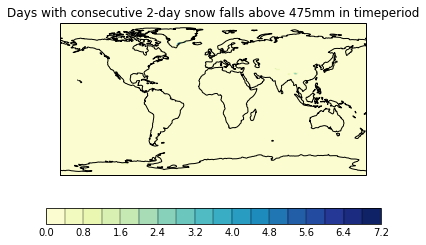

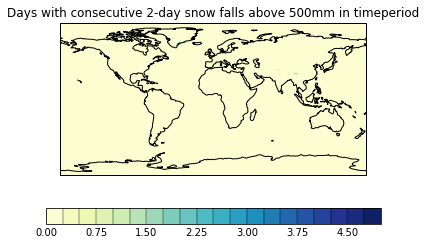

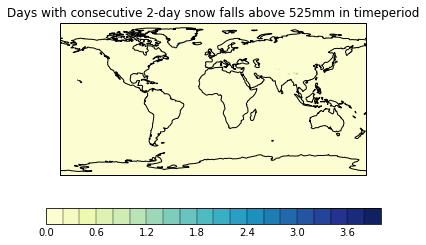

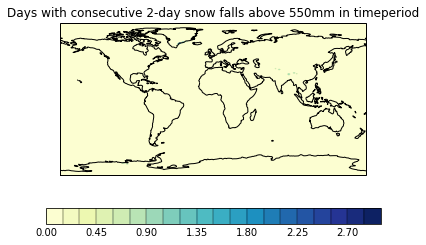

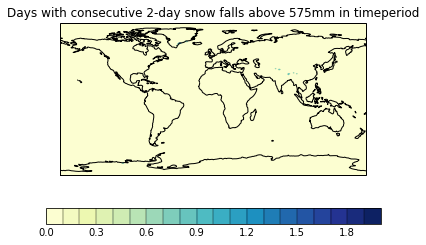

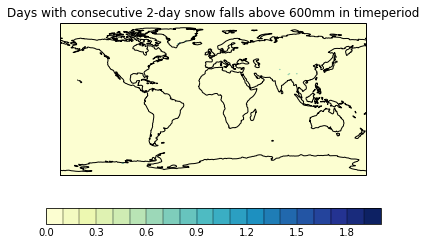

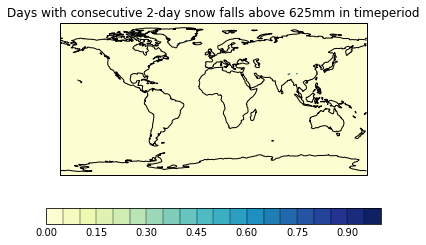

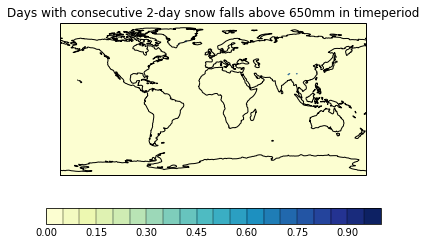

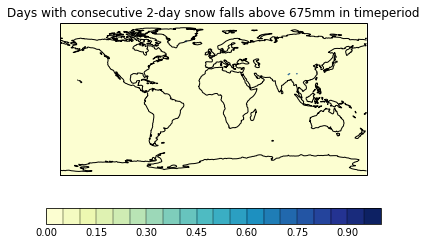

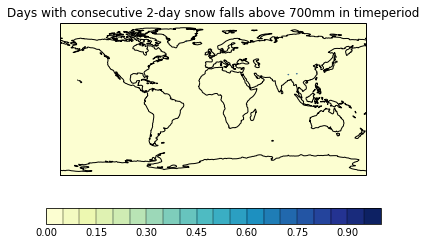

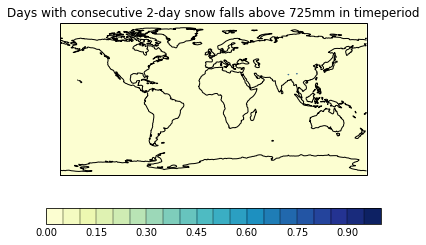

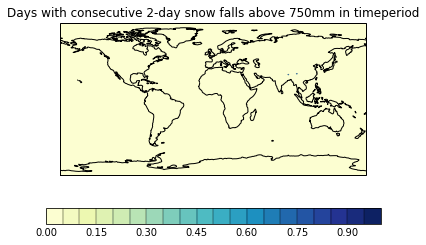

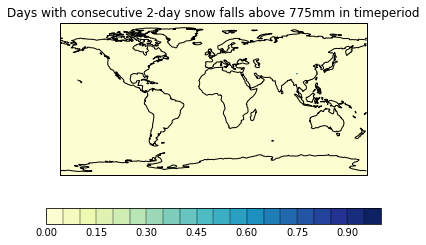

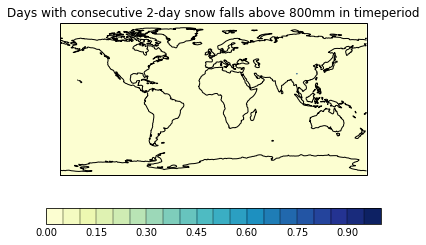

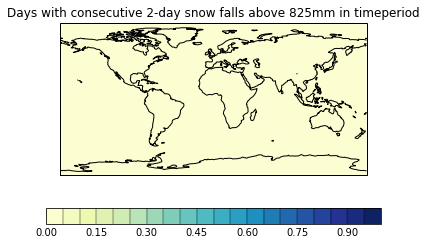

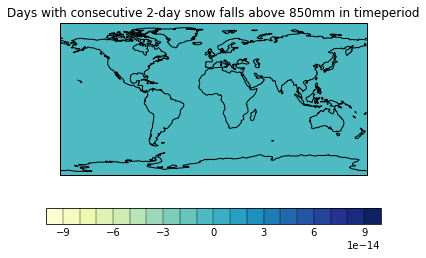

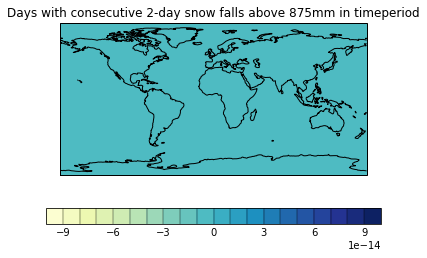

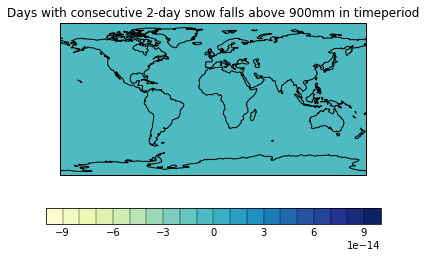

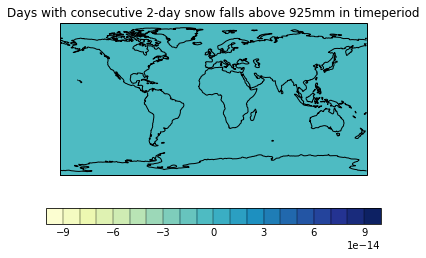

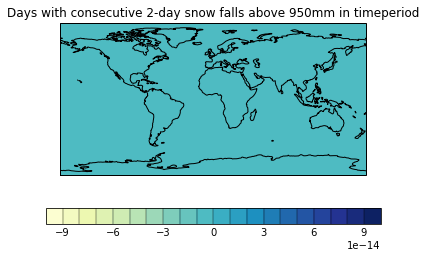

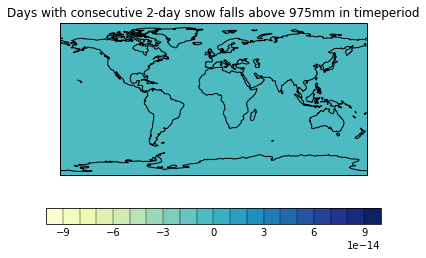

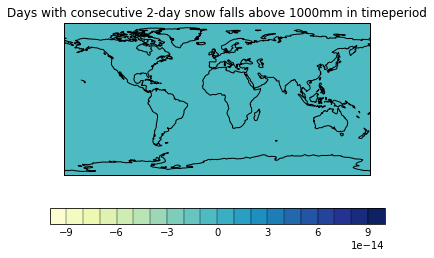

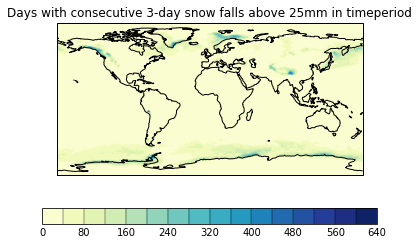

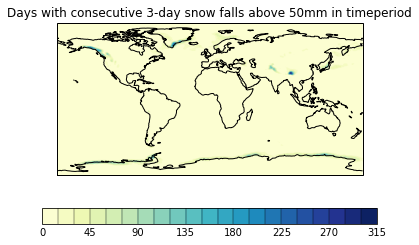

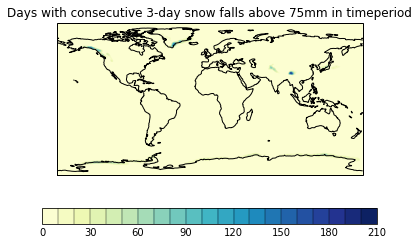

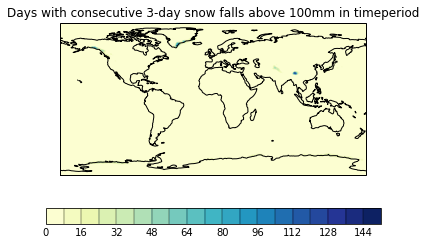

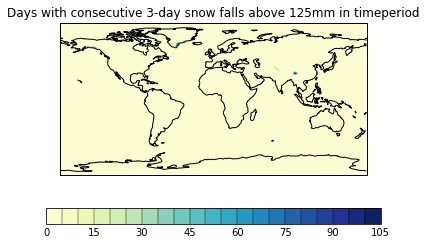

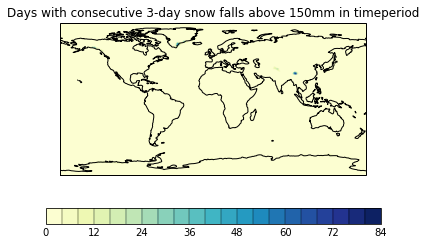

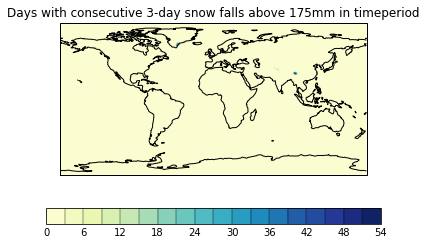

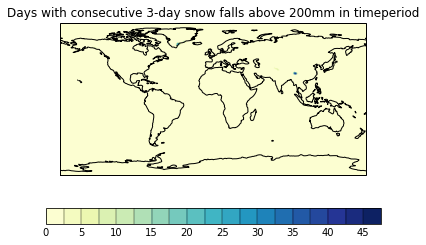

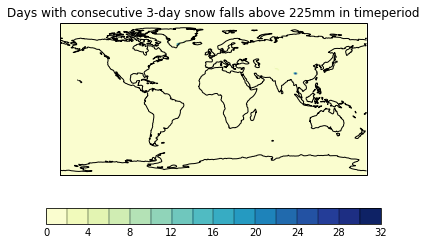

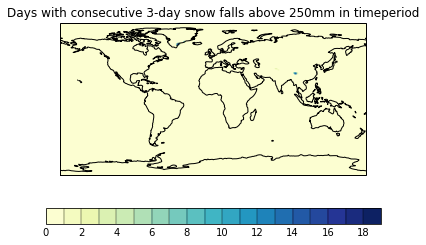

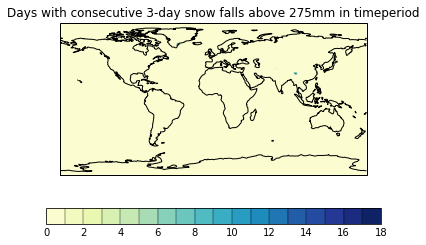

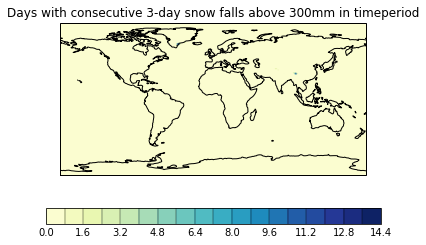

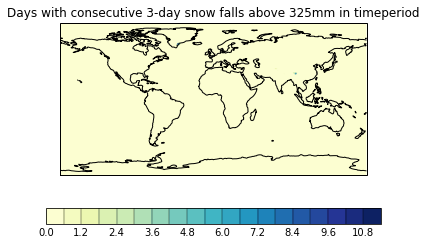

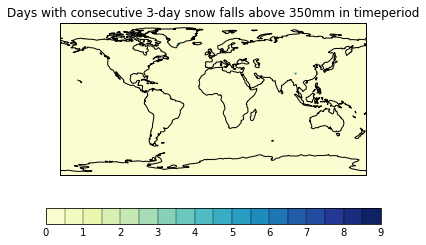

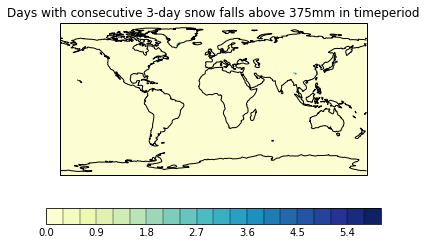

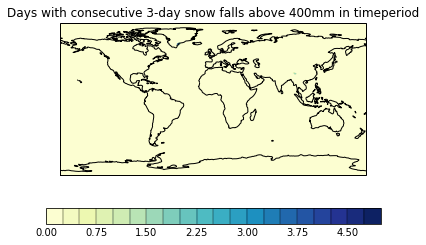

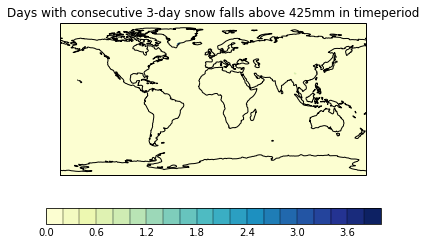

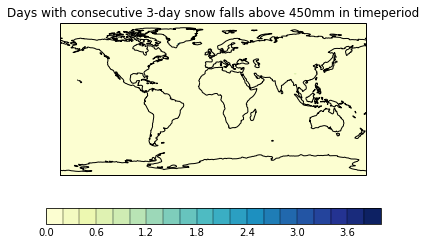

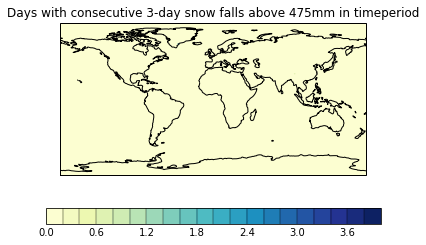

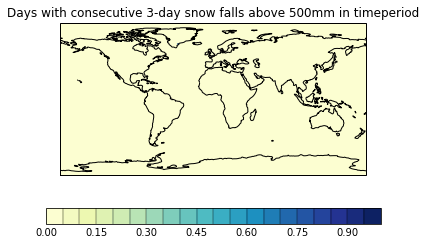

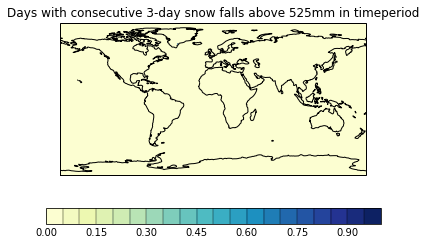

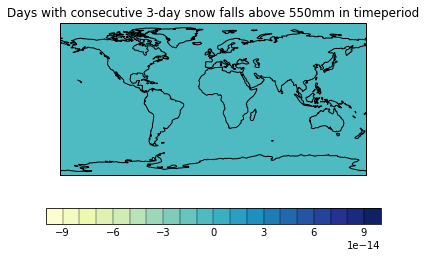

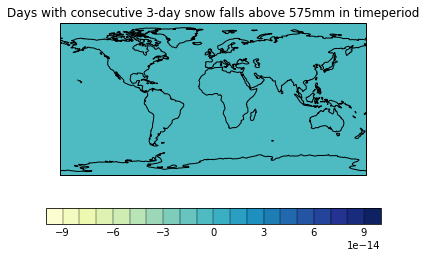

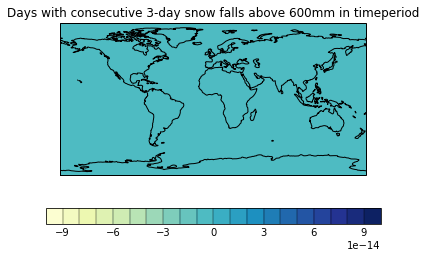

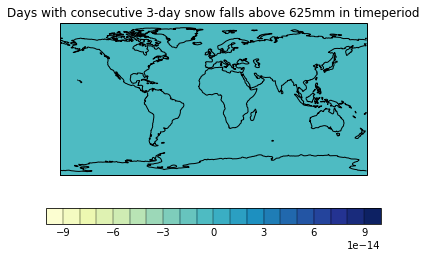

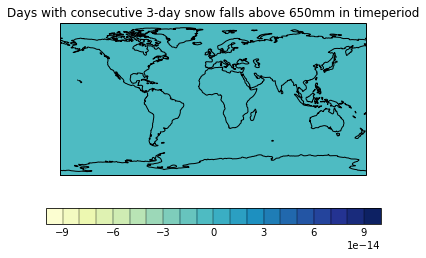

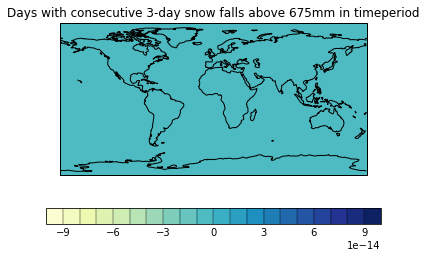

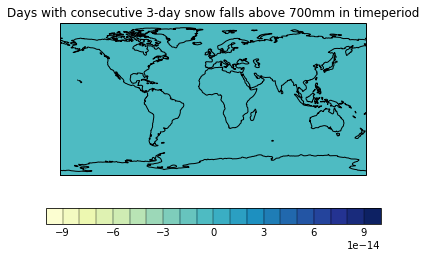

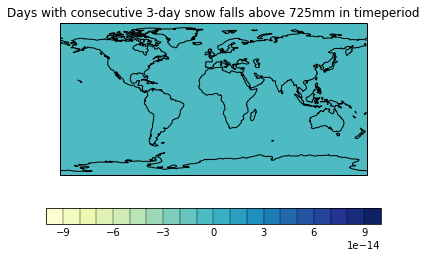

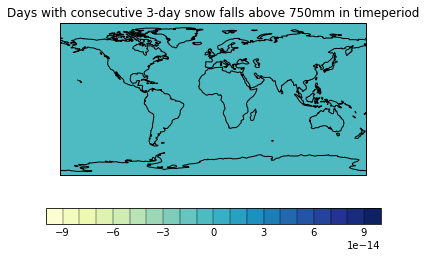

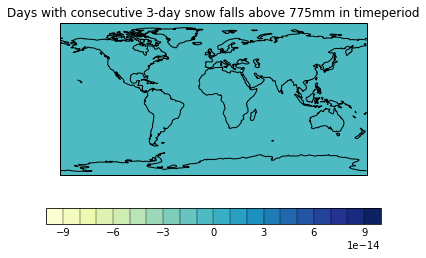

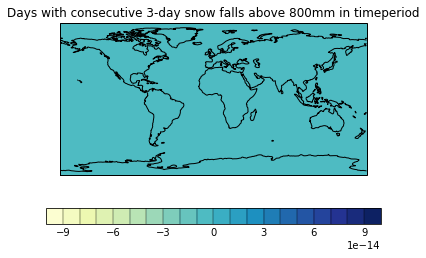

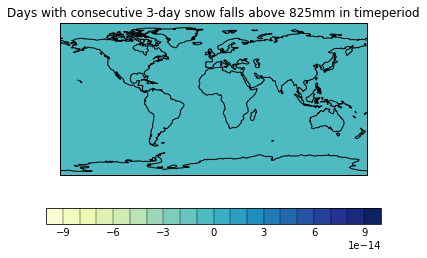

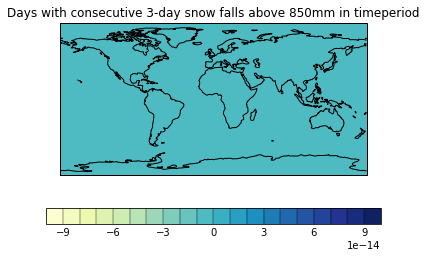

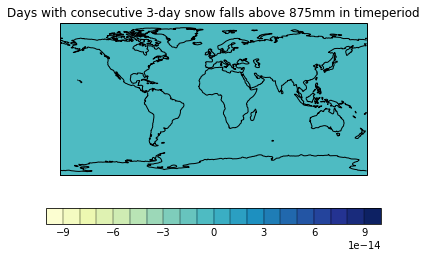

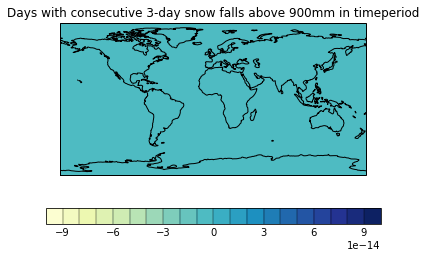

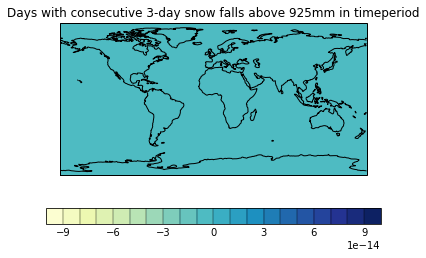

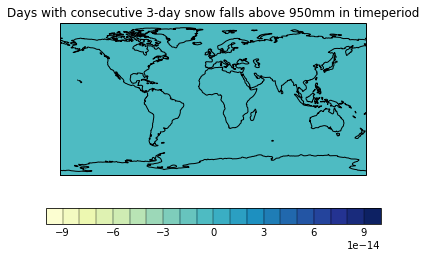

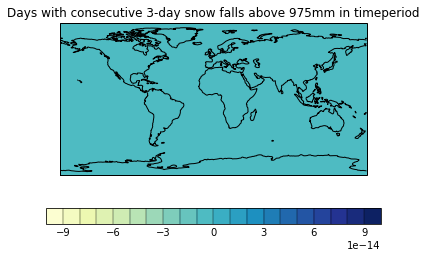

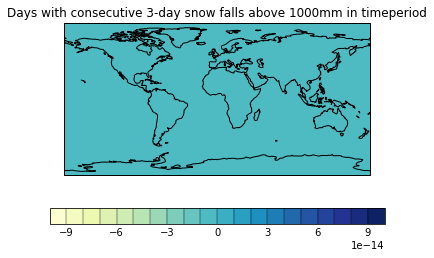

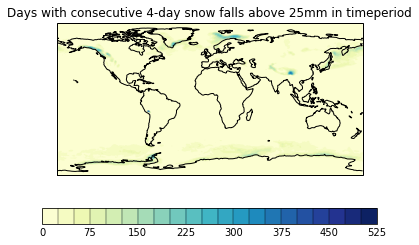

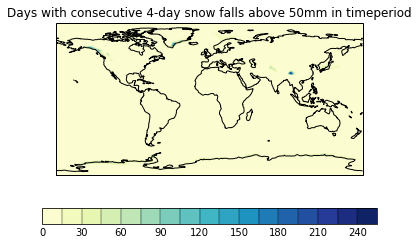

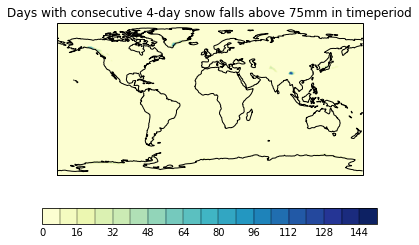

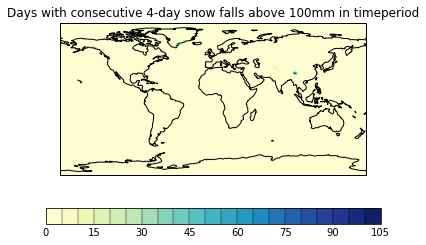

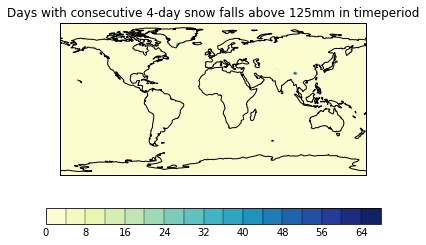

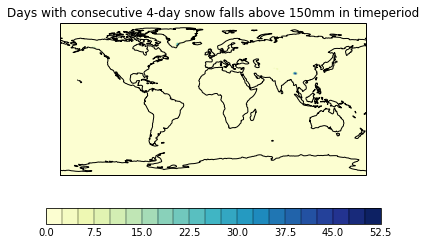

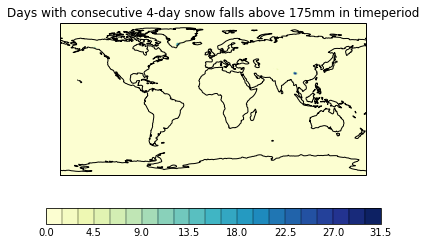

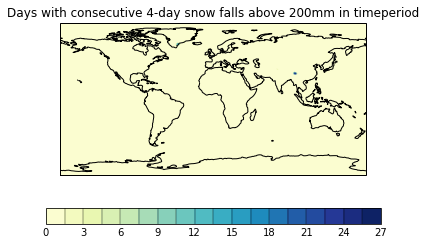

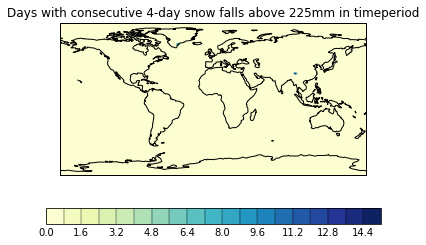

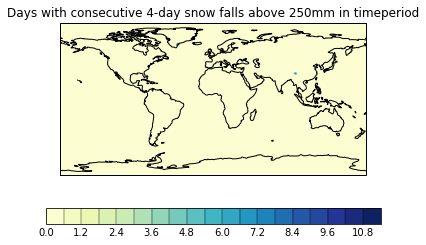

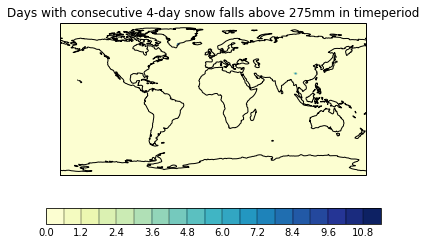

In [ ]:
# retrieve data
data = load_data_from_netcdf('/home/quante/CLionProjects/SnowProcessing/output.nc')
cube_daily = get_cube_from_cubelist(data,0)
cube_change = get_cube_from_cubelist(data,2)
datalist = []
datalist.append(cube_daily)
datalist.append(cube_change)
# define thresholds
#depth thresholds
depth_thresholds = np.arange(100,1001,100)
# time thresholds
time_thresholds = np.arange(1,5,1)

# loop over thresholds, calculate and plot results
contour_levels = 20
for i_data in datalist:
    for i_time in time_thresholds:
        for i_depth in depth_thresholds:
            contour_plot_intensity_data(calculate_data_above_threshold_for_x_days(i_data,i_depth,i_time),contour_levels)